In [1]:
source("http://bioconductor.org/biocLite.R")
biocLite("edgeR")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.1 (2016-06-21).
Installing package(s) ‘edgeR’
also installing the dependencies ‘limma’, ‘locfit’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'car', 'caret', 'chron', 'cluster', 'codetools',
  'colorspace', 'crayon', 'curl', 'data.table', 'DBI', 'digest', 'dplyr',
  'evaluate', 'foreign', 'ggplot2', 'htmlwidgets', 'httr', 'IRdisplay',
  'jsonlite', 'knitr', 'lattice', 'maps', 'Matrix', 'mgcv', 'mime', 'openssl',
  'pbdZMQ', 'quantmod', 'quantreg', 'R6', 'rbokeh', 'Rcpp', 'RcppEigen',
  'repr', 'reshape2', 'rmarkdown', 'scales', 'shiny', 'SparseM', 'stringi',
  'stringr', 'survival', 'tibble', 'tidyr', 'yaml'


In [2]:
library(edgeR)
setwd("~/Documents/HBOI/Past_salinity/Porites_astreoites_larvae_salinity/RNAseq")

Loading required package: limma


In [3]:
salinity_counts<-read.csv("salinity_v_mansour_counts.csv")

In [4]:
dim(salinity_counts)
rownames(salinity_counts)<-salinity_counts$Name
salinity_counts_table<-salinity_counts[,c(2:4)]
class(salinity_counts_table)

[1] 868830      4

[1] "data.frame"

In [5]:
too.low<-apply(salinity_counts_table, 1, function(row) all(row >=10 ))
salinity.rnaseq.data.filtered<-salinity_counts_table[too.low,]
dim(salinity.rnaseq.data.filtered)
# try this if want to see expression >100
#dim(salinity.rnaseq.data.matrix[rowSums(salinity.rnaseq.data.matrix)>100,])
#salinity.rnaseq.data.filtered<-salinity.rnaseq.data.matrix[rowSums(salinity.rnaseq.data.matrix)>100,]

[1] 50638     3

In [6]:
group <- factor(c(1,2,3))
design <- model.matrix(~group)
design

,(Intercept),group2,group3
1,1,0,0
2,1,1,0
3,1,0,1


In [7]:
y <- DGEList(counts=salinity.rnaseq.data.filtered,group=group)
y$samples
levels(y$samples$group)
head(y$counts)

,group,lib.size,norm.factors
X25ppt.quant,1,31925340.3902,1
X30ppt.quant,2,12700025.8891,1
X35ppt.quant,3,30722454.4884,1


[1] "1" "2" "3"

,X25ppt.quant,X30ppt.quant,X35ppt.quant
TR34_c0_g1_i1,38.8741,26.0000,31.0000
TR95_c0_g1_i1,32,16,22
TR450_c0_g1_i1,11,20,27
TR744_c0_g1_i1,37,17,35
TR1018_c0_g1_i1,64,12,25
TR1053_c0_g1_i1,144,65,135


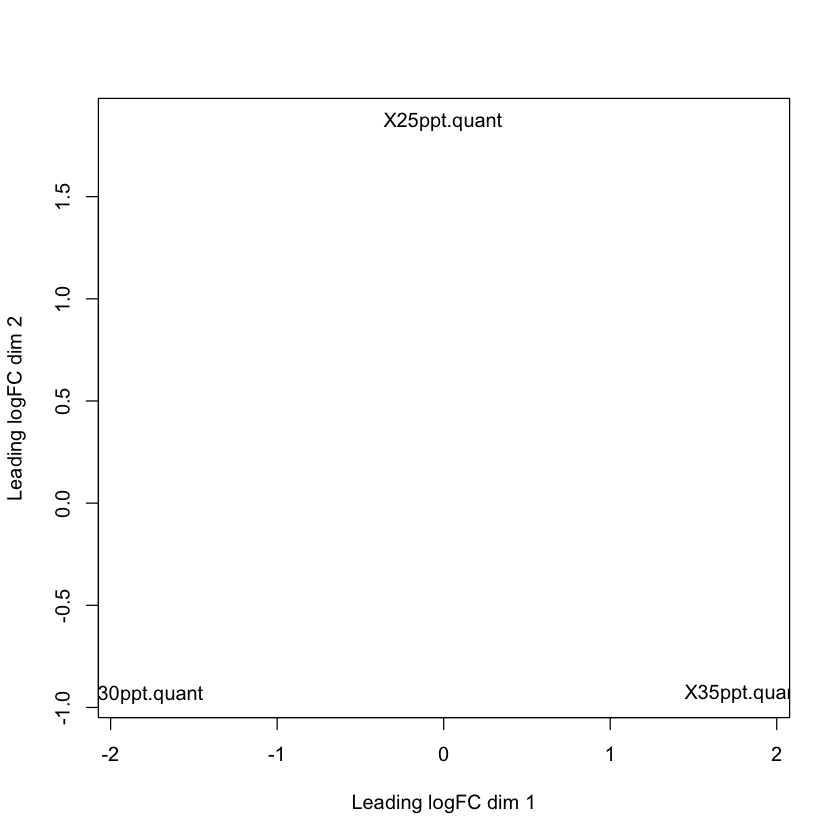

In [8]:
bcv <- 0.4
CPM <- cpm(y)
#head(CPM)
#head(CPM_table)
CPM_table<-cbind(CPM,rownames(CPM))
#head(CPM_table)
#class(CPM_table)
CPM_table<-as.data.frame(CPM_table)
colnames(CPM_table)<-c("sal25ppt","sal30ppt","sal35ppt","contig_ID")
plotMDS(y)

In [9]:
#et<-exactTest(y,dispersion=bcv^2)
et_30ppt <- exactTest(y, dispersion=bcv^2, pair=c(3,2))
et_25ppt <- exactTest(y, dispersion=bcv^2, pair=c(3,1))

sal30_ppt<-topTags(et_30ppt,n=100,sort.by="logFC")$table
#head(sal30_ppt)
sal30ppt_annotated<-cbind(sal30_ppt,rownames(sal30_ppt))
#head(sal30ppt_annotated)
colnames(sal30ppt_annotated)<-c("logFC","logCPM","PValue","FDR","contig_ID")
sal30ppt_annotated<-merge(sal30ppt_annotated,CPM_table,by="contig_ID")
#head(sal30ppt_annotated)
#write.csv(sal30ppt_annotated,"P_ast_RNAseq_30pptv35ppt_top100DE.csv")

sal25_ppt<-topTags(et_25ppt,n=100,sort.by="logFC")$table
#head(sal25_ppt)
sal25ppt_annotated<-cbind(sal25_ppt,rownames(sal25_ppt))
#head(sal25ppt_annotated)
colnames(sal25ppt_annotated)<-c("logFC","logCPM","PValue","FDR","contig_ID")
sal25ppt_annotated<-merge(sal25ppt_annotated,CPM_table,by="contig_ID")
#head(sal25ppt_annotated)
#write.csv(sal25ppt_annotated,"P_ast_RNAseq_25pptv35ppt_top100DE.csv")

In [15]:
# from Tamer's annotations:
# /mnt/ls15/scratch/users/mansourt/Tamer/p_ast_asm/uniprot_sprot.blastx.outfmt6.sig
# sed 's_|_-_g' uniprot_sprot.blastx.outfmt6.sig > uniprot_sprot.blastx.outfmt6.fixed.sig
# cut -f 1,2,17 reference/uniprot_sprot.blastx.outfmt6.fixed.sig > reference/uniprot_sprot.blastx.outfmt6.fixed.genes.sig
# touch uniprot_P_ast_annotations_mansour_hits100DE.tab
# for i in $(cut -f 2 P_ast_RNAseq_25pptv35ppt_top100DE.tab); do grep ${i/_/-} reference/uniprot_sprot.blastx.outfmt6.fixed.genes.sig >> uniprot_P_ast_annotations_mansour_hits100DE.tab; done
# sed 's/\-/\_/1' uniprot_P_ast_annotations_mansour_hits100DE.tab > uniprot_P_ast_annotations_mansour_hits100DE.fixed.tab

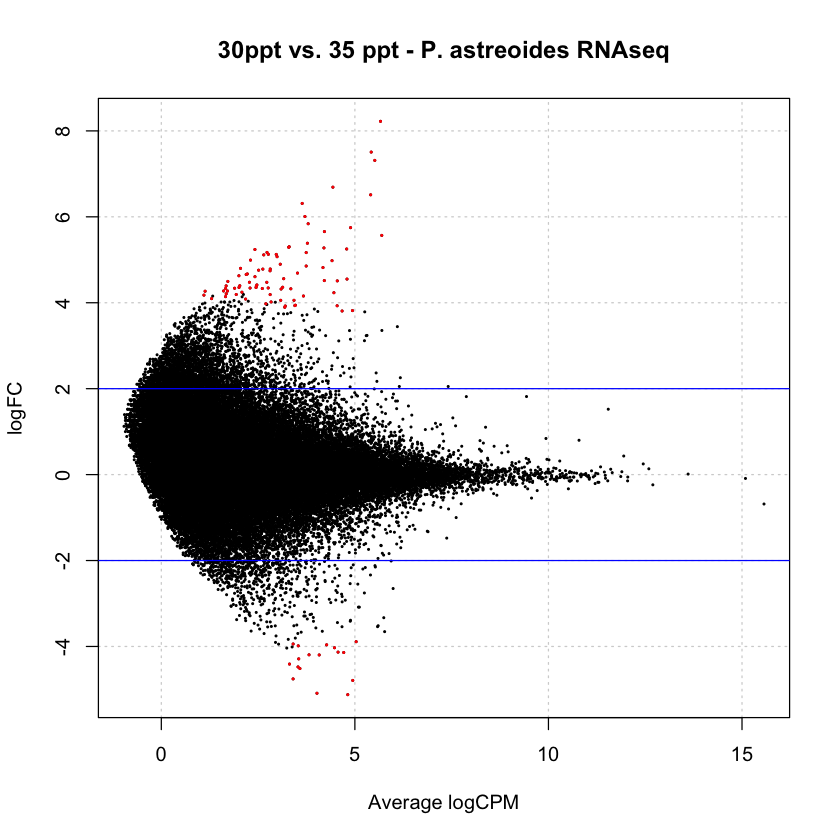

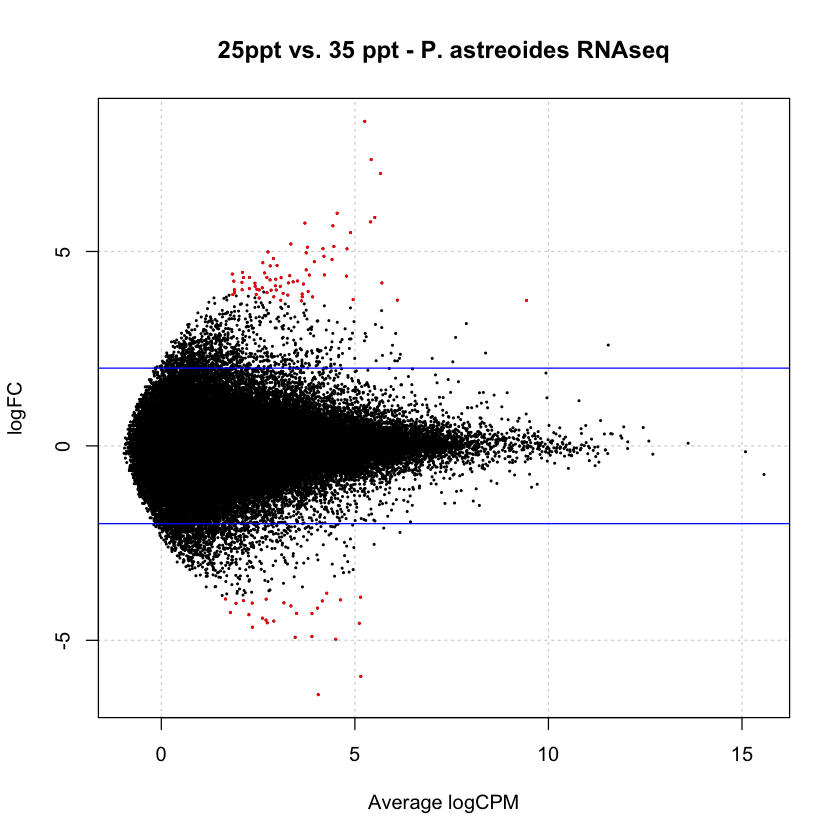

In [10]:
detags_30ppt <- rownames(topTags(et_30ppt,n=100)$table)
detags_25ppt <- rownames(topTags(et_25ppt,n=100)$table)
plotSmear(et_30ppt, de.tags=detags_30ppt,main="30ppt vs. 35 ppt - P. astreoides RNAseq")
abline(h = c(-2, 2), col = "blue")
plotSmear(et_25ppt,de.tags=detags_25ppt,main="25ppt vs. 35 ppt - P. astreoides RNAseq")
abline(h = c(-2, 2), col = "blue")

In [11]:
annotations=read.table("uniprot_P_ast_annotations_mansour_hits100DE.fixed.tab",sep="\t")
colnames(annotations)<-c("contig_ID","species","gene_name")
sal30ppt_annotated_again<-merge(sal30ppt_annotated,annotations,by="contig_ID")
sal25ppt_annotated_again<-merge(sal25ppt_annotated,annotations,by="contig_ID")
write.csv(sal25ppt_annotated_again,"P_ast_RNAseq_25pptv35ppt_top100DE.csv")
write.csv(sal30ppt_annotated_again,"P_ast_RNAseq_30pptv35ppt_top100DE.csv")

In [12]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin11.0.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_3.16.4         limma_3.30.6         BiocInstaller_1.24.0

loaded via a namespace (and not attached):
 [1] locfit_1.5-9.1  lattice_0.20-33 digest_0.6.9    crayon_1.3.1   
 [5] IRdisplay_0.4.3 grid_3.3.1      repr_0.7        R6_2.1.2       
 [9] jsonlite_0.9.22 magrittr_1.5    evaluate_0.9    stringi_1.1.1  
[13] uuid_0.1-2      IRkernel_0.7    tools_3.3.1     stringr_1.0.0  
[17] memoise_1.0.0   pbdZMQ_0.2-3   